In [2]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.2.1')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [16]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [17]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [18]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [19]:
from jcopdl.layers import conv_block, linear_block

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax"),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [21]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation -> MCOC

In [22]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [23]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6927 | Test_cost  = 0.6910 | Train_score = 0.5240 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6917 | Test_cost  = 0.6841 | Train_score = 0.5330 | Test_score = 0.7075 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6770 | Test_cost  = 0.6611 | Train_score = 0.6750 | Test_score = 0.5625 |
==> EarlyStop patience =  1 | Best test_score: 0.7075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6272 | Test_cost  = 0.5723 | Train_score = 0.6720 | Test_score = 0.7075 |
==> EarlyStop patience =  2 | Best test_score: 0.7075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5708 | Test_cost  = 0.5407 | Train_score = 0.7180 | Test_score = 0.7425 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5144 | Test_cost  = 0.4794 | Train_score = 0.7570 | Test_score = 0.7950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4735 | Test_cost  = 0.4415 | Train_score = 0.7830 | Test_score = 0.7975 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4411 | Test_cost  = 0.4232 | Train_score = 0.7900 | Test_score = 0.8125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4473 | Test_cost  = 0.4173 | Train_score = 0.7970 | Test_score = 0.8250 |


Train:   0%|          | 0/8 [02:40<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4331 | Test_cost  = 0.4972 | Train_score = 0.8050 | Test_score = 0.7825 |
==> EarlyStop patience =  1 | Best test_score: 0.8250


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4650 | Test_cost  = 0.4642 | Train_score = 0.7800 | Test_score = 0.8025 |
==> EarlyStop patience =  2 | Best test_score: 0.8250


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4411 | Test_cost  = 0.3847 | Train_score = 0.7980 | Test_score = 0.8300 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.4036 | Test_cost  = 0.3817 | Train_score = 0.8240 | Test_score = 0.8275 |
==> EarlyStop patience =  1 | Best test_score: 0.8300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3914 | Test_cost  = 0.3953 | Train_score = 0.8200 | Test_score = 0.8100 |
==> EarlyStop patience =  2 | Best test_score: 0.8300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3685 | Test_cost  = 0.3931 | Train_score = 0.8320 | Test_score = 0.8175 |
==> EarlyStop patience =  3 | Best test_score: 0.8300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3848 | Test_cost  = 0.3546 | Train_score = 0.8310 | Test_score = 0.8475 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3646 | Test_cost  = 0.3821 | Train_score = 0.8380 | Test_score = 0.8250 |
==> EarlyStop patience =  1 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3705 | Test_cost  = 0.3979 | Train_score = 0.8350 | Test_score = 0.8025 |
==> EarlyStop patience =  2 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3640 | Test_cost  = 0.3975 | Train_score = 0.8460 | Test_score = 0.8050 |
==> EarlyStop patience =  3 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3541 | Test_cost  = 0.3657 | Train_score = 0.8480 | Test_score = 0.8225 |


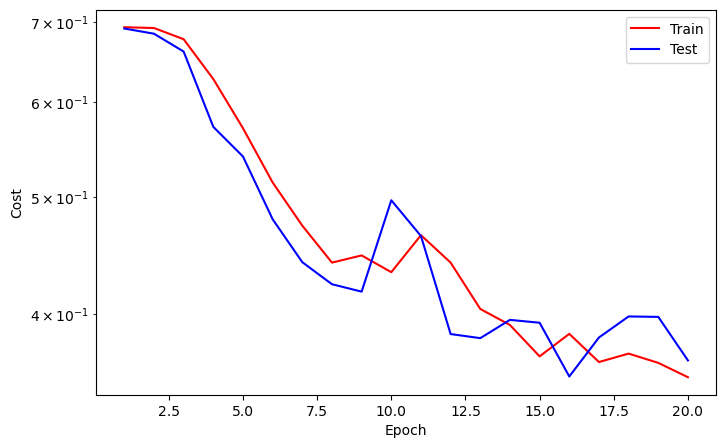

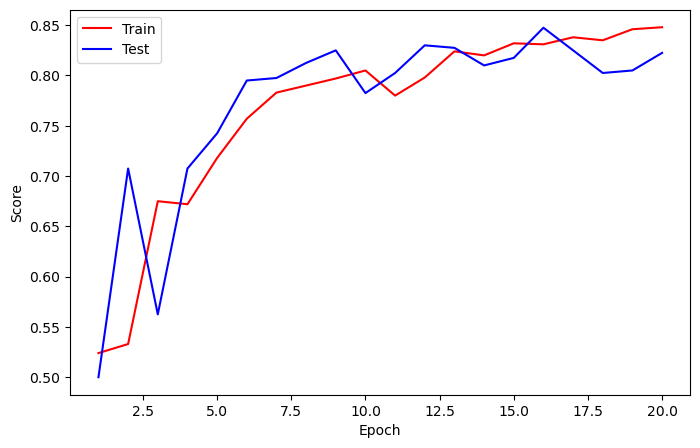

==> EarlyStop patience =  4 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3409 | Test_cost  = 0.3280 | Train_score = 0.8460 | Test_score = 0.8500 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3245 | Test_cost  = 0.3274 | Train_score = 0.8580 | Test_score = 0.8675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3259 | Test_cost  = 0.3757 | Train_score = 0.8660 | Test_score = 0.8125 |
==> EarlyStop patience =  1 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3340 | Test_cost  = 0.3234 | Train_score = 0.8500 | Test_score = 0.8650 |
==> EarlyStop patience =  2 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3153 | Test_cost  = 0.3677 | Train_score = 0.8650 | Test_score = 0.8325 |
==> EarlyStop patience =  3 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3279 | Test_cost  = 0.3722 | Train_score = 0.8630 | Test_score = 0.8275 |
==> EarlyStop patience =  4 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3486 | Test_cost  = 0.3047 | Train_score = 0.8590 | Test_score = 0.8700 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3055 | Test_cost  = 0.3171 | Train_score = 0.8670 | Test_score = 0.8700 |
==> EarlyStop patience =  1 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2854 | Test_cost  = 0.3112 | Train_score = 0.8850 | Test_score = 0.8775 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2990 | Test_cost  = 0.3265 | Train_score = 0.8730 | Test_score = 0.8675 |
==> EarlyStop patience =  1 | Best test_score: 0.8775


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.3159 | Test_cost  = 0.3288 | Train_score = 0.8720 | Test_score = 0.8525 |
==> EarlyStop patience =  2 | Best test_score: 0.8775


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2913 | Test_cost  = 0.2950 | Train_score = 0.8790 | Test_score = 0.8800 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.2790 | Test_cost  = 0.3221 | Train_score = 0.8880 | Test_score = 0.8475 |
==> EarlyStop patience =  1 | Best test_score: 0.8800


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2736 | Test_cost  = 0.2867 | Train_score = 0.8820 | Test_score = 0.8875 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.3012 | Test_cost  = 0.2920 | Train_score = 0.8700 | Test_score = 0.8825 |
==> EarlyStop patience =  1 | Best test_score: 0.8875


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2813 | Test_cost  = 0.2729 | Train_score = 0.8750 | Test_score = 0.8875 |
==> EarlyStop patience =  2 | Best test_score: 0.8875


Train:   0%|          | 0/8 [02:40<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.2836 | Test_cost  = 0.2942 | Train_score = 0.8730 | Test_score = 0.8775 |
==> EarlyStop patience =  3 | Best test_score: 0.8875


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.2571 | Test_cost  = 0.2933 | Train_score = 0.8880 | Test_score = 0.8775 |
==> EarlyStop patience =  4 | Best test_score: 0.8875


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.2471 | Test_cost  = 0.3133 | Train_score = 0.8970 | Test_score = 0.8750 |
==> EarlyStop patience =  5 | Best test_score: 0.8875
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.8875
==> Best model is saved at model


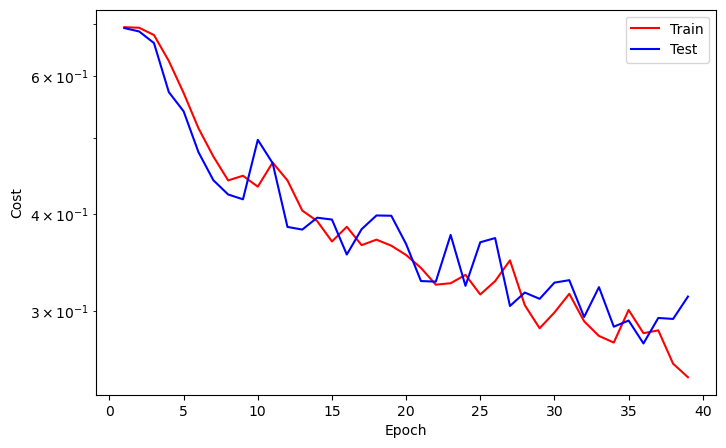

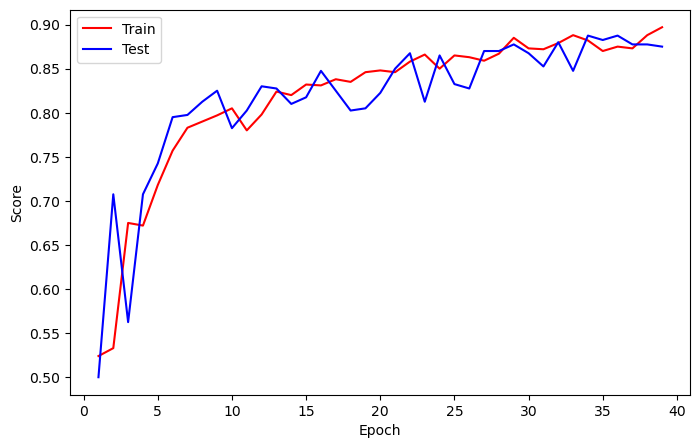

In [24]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
        
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [27]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [28]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0])

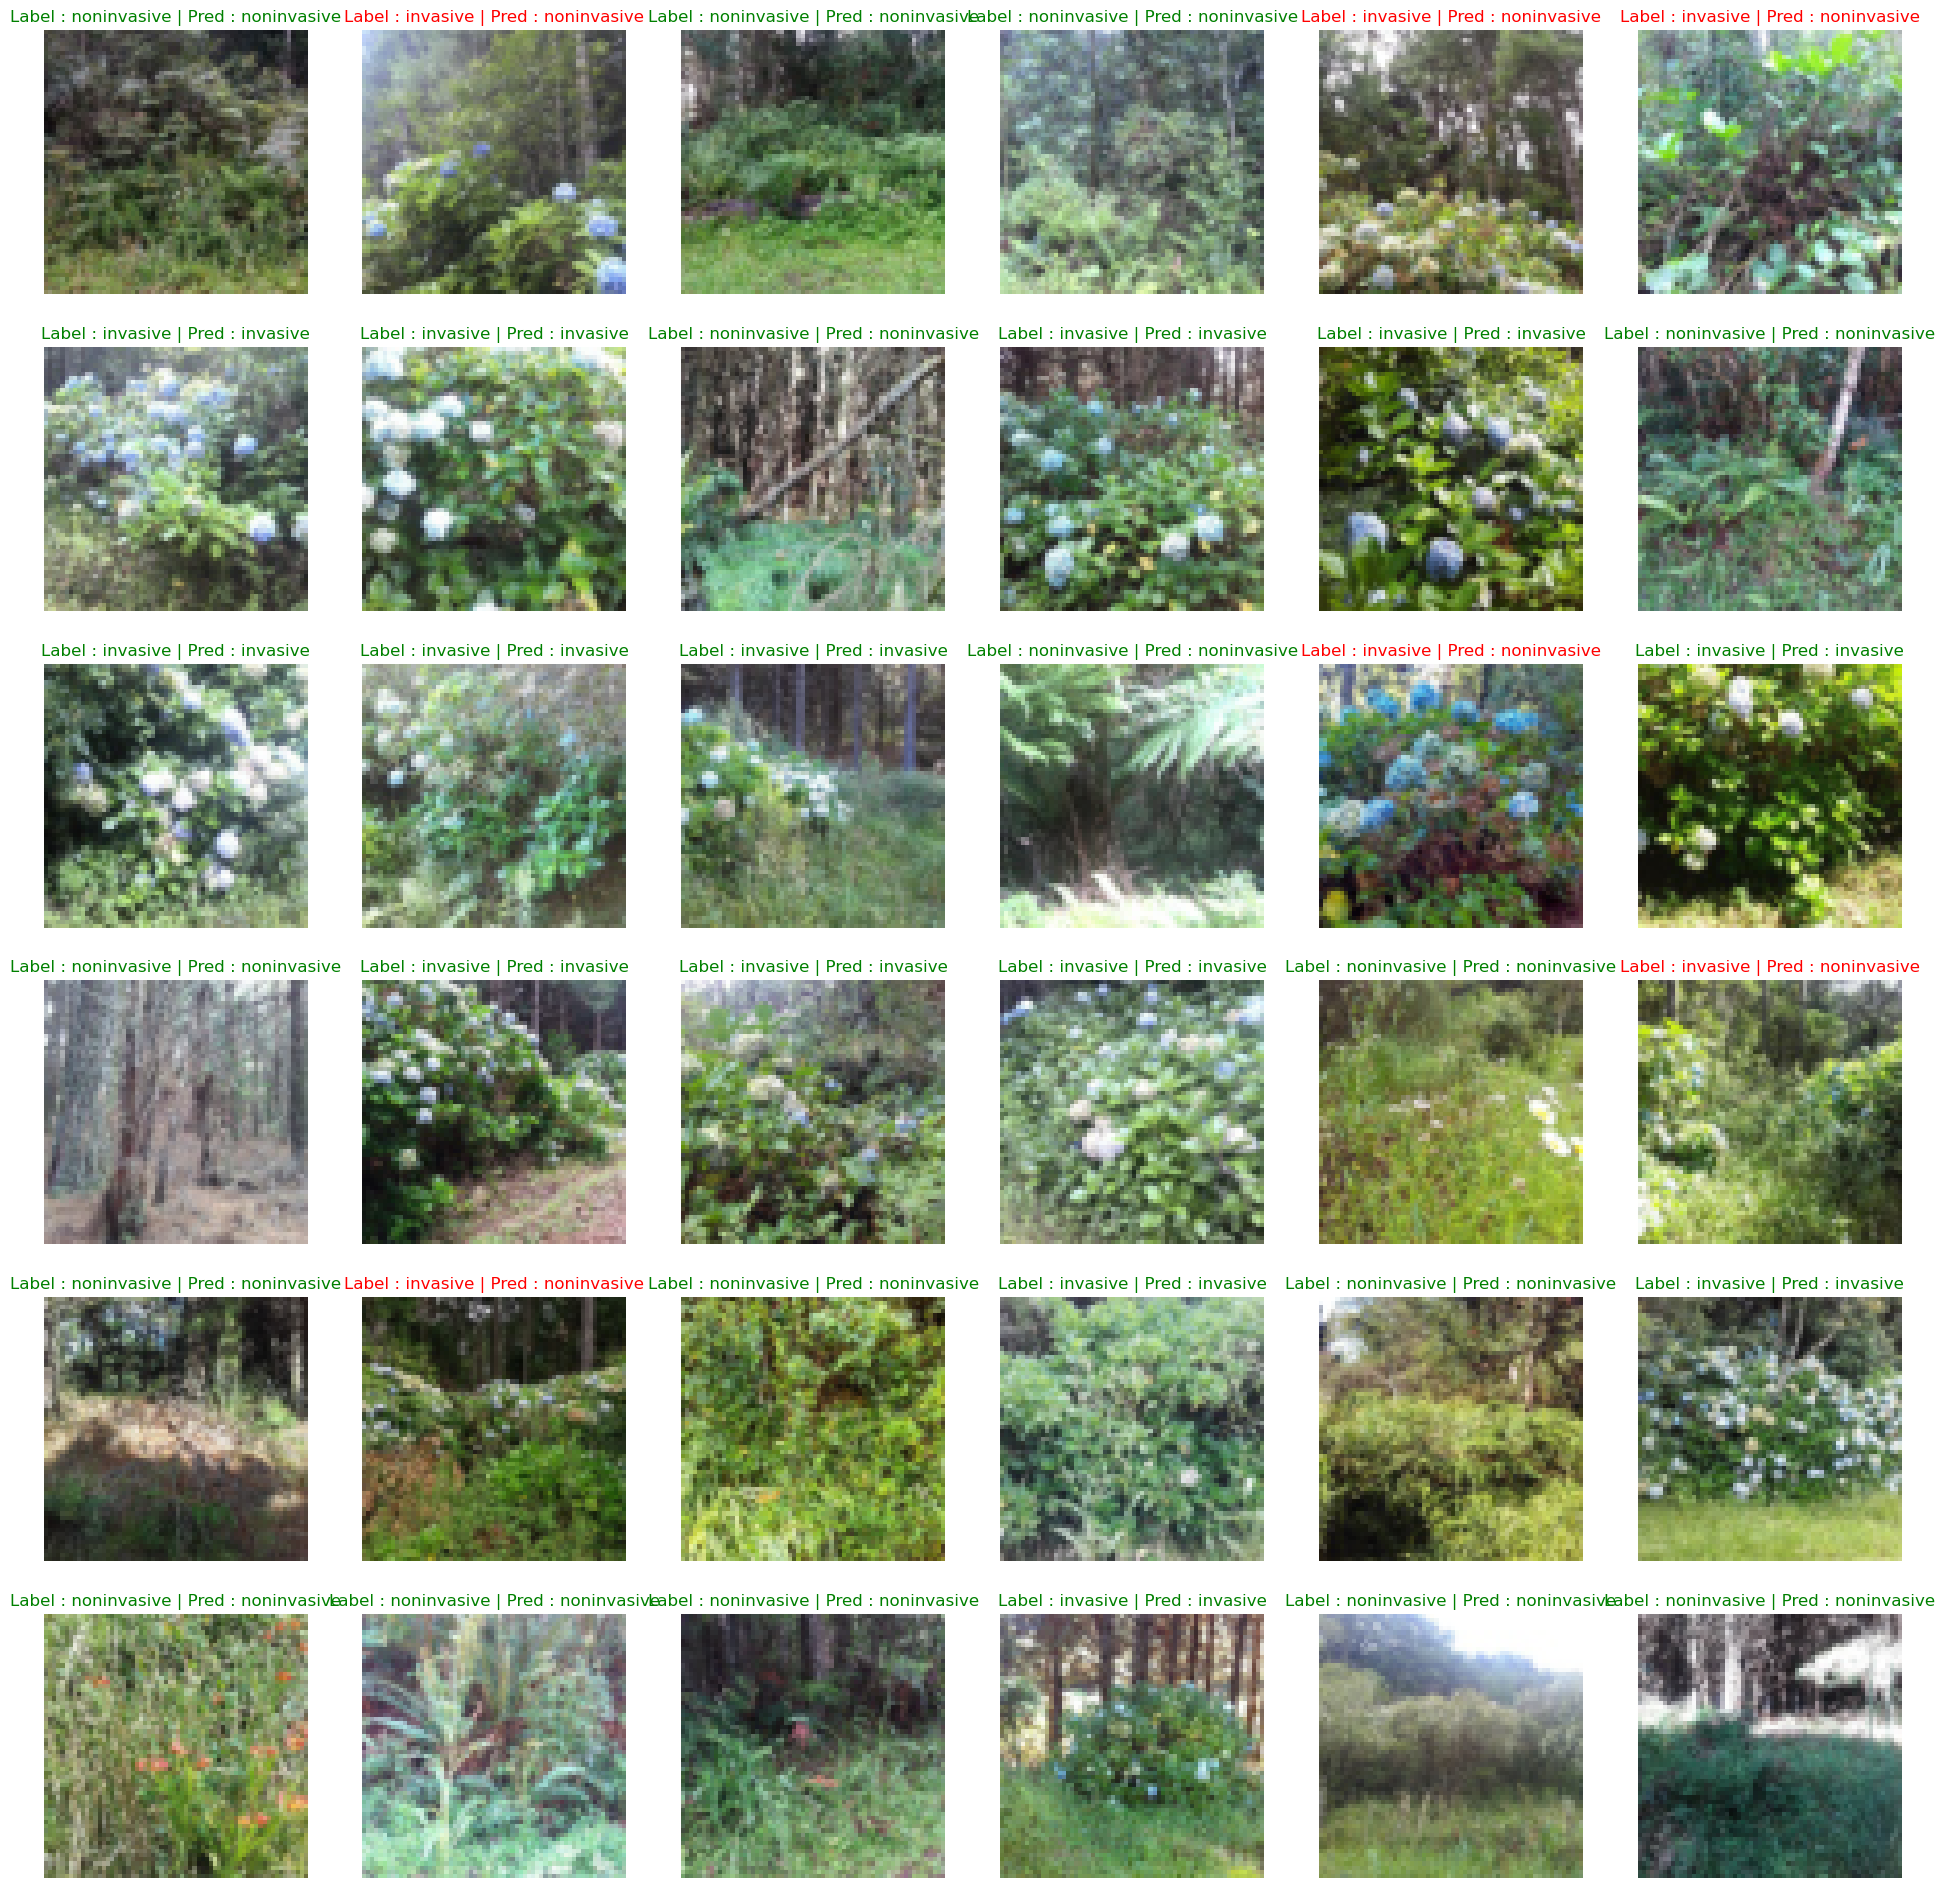

In [31]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu(), cmap="gray")
    font = {"color" : "r"} if label != pred else {"color" : "g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred : {pred}", fontdict=font);
    ax.axis("off");